In [20]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [2]:
!pip install ipydeps

     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 2.7MB 25.1MB/s 
  Created wheel for ipydeps: filename=ipydeps-0.10.0-cp36-none-any.whl size=10798 sha256=7f91c4519953b11ccc5618c574807d2b6df8d59b59dd4164f9bd3bc93dbab403
  Stored in directory: /root/.cache/pip/wheels/e3/4a/6f/2a1810efd60598edd3f3a3d800bb46f734407dd62c18710534
  Created wheel for pypki2: filename=pypki2-0.11.0-cp36-none-any.whl size=10428 sha256=7a420d748c6c677ce12c2eba46190856e613907a8cfd396095dd0c193798983b
  Stored in directory: /root/.cache/pip/wheels/94/40/0b/348ab8c4a7ccd1f846f0b7a011065f70b06a53c7accf84a301
Successfully built ipydeps pypki2


In [3]:
import ipydeps
ipydeps.pip(["keras-rl", "gym"])

In [4]:
!pip uninstall tensorflow==2.0.0-beta

Uninstalling tensorflow-2.2.0rc4:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc4


In [5]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 104kB/s 
     |████████████████████████████████| 368kB 46.6MB/s 
     |████████████████████████████████| 3.2MB 43.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1


In [0]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [0]:
import gym
from gym import spaces
from gym.utils import seeding
rrewards = 0

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        global rrewards
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                rrewards = -1
                reward = -1.
            else:
                done = False
                rrewards = 0
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            rrewards = cmp(score(self.player), score(self.dealer))
            reward = cmp(score(self.player), score(self.dealer))
            if is_natural(self.player) and reward == 1.:
                rrewards = 1.5
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [0]:
env = BlackjackEnv()
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [0]:
from keras.callbacks import LambdaCallback, CSVLogger, TensorBoard

log1 = [[]]
def on_epoch_end(epoch, logs):
    log1[0].append(rrewards)
rl_cb = LambdaCallback(on_epoch_end=on_epoch_end)
rb_list = [rl_cb]

In [89]:
model = Sequential()
model.add(Flatten(input_shape=(1,3)))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                64        
_________________________________________________________________
activation_28 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_29 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_30 (Activation)   (None, 16)               

In [0]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=5, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [116]:
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 164s 16ms/step - reward: -0.1578
7228 episodes - episode_reward: -0.218 [-1.000, 1.500] - loss: 0.257 - mae: 0.535 - mean_q: 0.006

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 161s 16ms/step - reward: -0.1578
7224 episodes - episode_reward: -0.219 [-1.000, 1.500] - loss: 0.258 - mae: 0.536 - mean_q: 0.004

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 163s 16ms/step - reward: -0.1595
7206 episodes - episode_reward: -0.221 [-1.000, 1.500] - loss: 0.259 - mae: 0.532 - mean_q: 0.002

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 163s 16ms/step - reward: -0.1549
7216 episodes - episode_reward: -0.215 [-1.000, 1.500] - loss: 0.260 - mae: 0.531 - mean_q: 0.001

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 162s 16ms/step - reward: -0.1603
718

In [117]:
len(log1[0])

0

In [118]:
tests = dqn.test(env, nb_episodes=20000, visualize=False, callbacks=rb_list)

Streaming output truncated to the last 5000 lines.
Episode 15002: reward: 1.000, steps: 2
Episode 15003: reward: 1.000, steps: 1
Episode 15004: reward: 0.000, steps: 3
Episode 15005: reward: 1.000, steps: 1
Episode 15006: reward: 1.500, steps: 1
Episode 15007: reward: 0.000, steps: 2
Episode 15008: reward: -1.000, steps: 1
Episode 15009: reward: -1.000, steps: 1
Episode 15010: reward: -1.000, steps: 1
Episode 15011: reward: -1.000, steps: 1
Episode 15012: reward: -1.000, steps: 2
Episode 15013: reward: 1.000, steps: 2
Episode 15014: reward: -1.000, steps: 1
Episode 15015: reward: -1.000, steps: 1
Episode 15016: reward: 1.000, steps: 1
Episode 15017: reward: 1.000, steps: 2
Episode 15018: reward: -1.000, steps: 1
Episode 15019: reward: 1.000, steps: 1
Episode 15020: reward: -1.000, steps: 2
Episode 15021: reward: -1.000, steps: 1
Episode 15022: reward: 1.500, steps: 1
Episode 15023: reward: 1.500, steps: 1
Episode 15024: reward: -1.000, steps: 1
Episode 15025: reward: 1.000, steps: 1
Ep

In [119]:
len(log1[0])

20000

-691.0


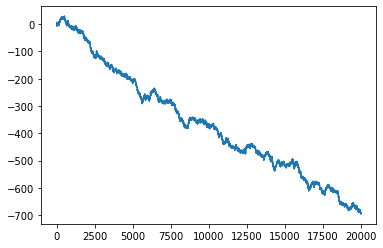

In [122]:
import matplotlib.pyplot as plt
import numpy as np
track = len(log1[0])
wander = 0
y = np.zeros(track)
for i in range(0, track):
  wander += log1[0][i]
  y[i] = wander
print(wander)
x = np.linspace(0, track, track)
plt.plot()
plt.plot(x, y)
#plt.plot(x, np.cos(x))

plt.show()